# Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator <br>-- Correctness Testing --

## This operator is contributed by Chevron Energy Technology Company (2020)

This operator is based on simplfications of the systems presented in:
<br>**Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1

## Introduction 

The goal of this tutorial set is to generate and prove correctness of modeling and inversion capability in Devito for variable density visco- acoustics using an energy conserving form of the wave equation. We describe how the linearization of the energy conserving *skew self adjoint* system with respect to modeling parameters allows using the same modeling system for all nonlinear and linearized forward and adjoint finite difference evolutions. There are three notebooks in this series:

##### 1. Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Nonlinear Ops
- Implement the nonlinear modeling operations. 
- [ssa_01_iso_implementation1.ipynb](ssa_01_iso_implementation1.ipynb)

##### 2. Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Linearized Ops
- Implement the linearized (Jacobian) ```forward``` and ```adjoint``` modeling operations.
- [ssa_02_iso_implementation2.ipynb](ssa_02_iso_implementation2.ipynb)

##### 3. Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Correctness Testing
- Tests the correctness of the implemented operators.
- [ssa_03_iso_correctness.ipynb](ssa_03_iso_correctness.ipynb)

There are similar series of notebooks implementing and testing operators for VTI and TTI anisotropy ([README.md](README.md)).

Below we describe a suite of unit tests that prove correctness for our *skew self adjoint* operators.

## Outline 
1. Define symbols [[link]](#c_symbols)
2. Definition of correctness tests [[link]](#c_howto)
3. Analytic response in the far field [[link]]("#c_analytic")
4. Modeling operator linearity test, with respect to source [[link]]("#c_F_linearity")
5. Modeling operator adjoint test, with respect to source [[link]]("#c_F_adjoint")
6. Nonlinear operator linearization test, with respect to model [[link]]("#c_F_linearization")
7. Jacobian operator linearity test, with respect to model [[link]]("#c_J_linearity")
8. Jacobian operator adjoint test, with respect to model [[link]]("#c_J_adjoint")
9. References [[link]]("#refs")

<a id="c_symbols"></a>
## Table of symbols

Note we are only showing the symbols here relevant to the correctness tests, for more detail on notations see the implementation notebooks that precede this one.

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
|:---|:---|:---|
| $\overleftarrow{\partial_t}$ | shifted first derivative wrt $t$ | shifted 1/2 sample backward in time |
| $\partial_{tt}$ | centered second derivative wrt $t$ | centered in time |
| $\overrightarrow{\partial_x},\ \overrightarrow{\partial_y},\ \overrightarrow{\partial_z}$ | + shifted first derivative wrt $x,y,z$ | shifted 1/2 sample forward in space |
| $\overleftarrow{\partial_x},\ \overleftarrow{\partial_y},\ \overleftarrow{\partial_z}$ | - shifted first derivative wrt $x,y,z$ | shifted 1/2 sample backward in space |
| $m(x,y,z)$ | Total P wave velocity ($m_0+\delta m$) | function of space |
| $m_0(x,y,z)$ | Reference P wave velocity    | function of space |
| $\delta m(x,y,z)$ | Perturbation to P wave velocity    | function of space |
| $u(t,x,y,z)$ | Total pressure wavefield ($u_0+\delta u$)| function of time and space |
| $u_0(t,x,y,z)$ | Reference pressure wavefield | function of time and space |
| $\delta u(t,x,y,z)$ | Perturbation to pressure wavefield | function of time and space |
| $s(t,x,y,z)$ | Source wavefield | function of time, localized in space to source location |
| $r(t,x,y,z)$ | Receiver wavefield | function of time, localized in space to receiver locations |
| $\delta r(t,x,y,z)$ | Receiver wavefield perturbation | function of time, localized in space to receiver locations |
| $F[m]\ q$ | Forward linear modeling operator | Nonlinear in $m$, linear in $q, s$: $\quad$ maps $q \rightarrow s$ |
| $\bigl( F[m] \bigr)^\top\ s$ | Adjoint linear modeling operator | Nonlinear in $m$, linear in $q, s$: $\quad$ maps $s \rightarrow q$ |
| $F[m; q]$ | Forward nonlinear modeling operator | Nonlinear in $m$, linear in $q$: $\quad$ maps $m \rightarrow r$ |
| $\nabla F[m; q]\ \delta m$ | Forward Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta m \rightarrow \delta r$ |
| $\bigl( \nabla F[m; q] \bigr)^\top\ \delta r$ | Adjoint Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta r \rightarrow \delta m$ |
| $\Delta_t, \Delta_x, \Delta_y, \Delta_z$ | sampling rates for $t, x, y , z$ | $t, x, y , z$ |  

## A word about notation 

We use the arrow symbols over derivatives $\overrightarrow{\partial_x}$ as a shorthand notation to indicate that the derivative is taken at a shifted location. For example:

- $\overrightarrow{\partial_x}\ u(t,x,y,z)$ indicates that the $x$ derivative of $u(t,x,y,z)$ is taken at $u(t,x+\frac{\Delta x}{2},y,z)$.

- $\overleftarrow{\partial_z}\ u(t,x,y,z)$ indicates that the $z$ derivative of $u(t,x,y,z)$ is taken at $u(t,x,y,z-\frac{\Delta z}{2})$.

- $\overleftarrow{\partial_t}\ u(t,x,y,z)$ indicates that the $t$ derivative of $u(t,x,y,z)$ is taken at $u(t-\frac{\Delta_t}{2},x,y,z)$.

We usually drop the $(t,x,y,z)$ notation from wavefield variables unless required for clarity of exposition, so that $u(t,x,y,z)$ becomes $u$.

<a id="c_howto"></a>
## Definition of correctness tests

We believe that if an operator passes the following suite of unit tests, it can be considered to be *righteous*.

## 1. Analytic response in the far field
Test that data generated in a wholespace matches analogous analytic data away from the near field. We re-use the material shown in the [examples/seismic/acoustic/accuracy.ipynb](https://github.com/devitocodes/devito/blob/master/examples/seismic/acoustic/accuracy.ipynb) notebook. 
<br>

## 2. Modeling operator linearity test, with respect to source
For random vectors $s$ and $r$, prove:

$$
\begin{aligned}
F[m]\ (\alpha\ s) &\approx \alpha\ F[m]\ s \\[5pt]
F[m]^\top (\alpha\ r) &\approx \alpha\ F[m]^\top r \\[5pt]
\end{aligned}
$$
## 3. Modeling operator adjoint test, with respect to source
For random vectors $s$ and $r$, prove:

$$
r \cdot F[m]\ s \approx s \cdot F[m]^\top r
$$

## 4. Nonlinear operator linearization test, with respect to model
For initial velocity model $m$ and random perturbation $\delta m$ prove that the $L_2$ norm error in the linearization $E(h)$ is second order (decreases quadratically) with the magnitude of the perturbation.

$$
E(h) = \biggl\|\ f(m+h\ \delta m) - f(m) - h\ \nabla F[m]\ \delta m\ \biggr\|
$$

One way to do this is to run a suite of $h$ values decreasing by a factor of $\gamma$, and prove the error decreases by a factor of $\gamma^2$:  

$$
\frac{E\left(h\right)}{E\left(h/\gamma\right)} \approx \gamma^2
$$

Elsewhere in Devito tutorials, this relation is proven by fitting a line to a sequence of $E(h)$ for various $h$ and showing second order error decrease. We employ this strategy here.

## 5. Jacobian operator linearity test, with respect to model
For initial velocity model $m$ and random vectors $\delta m$ and $\delta r$, prove:

$$
\begin{aligned}
\nabla F[m]\ (\alpha\ \delta m) &\approx \alpha\ \nabla F[m]\ \delta m \\[5pt]
(\nabla F[m])^\top (\alpha\ \delta r) &\approx \alpha\ (\nabla F[m])^\top \delta r
\end{aligned}
$$

## 6. Jacobian operator adjoint test, with respect to model
For initial velocity model $m$ and random vectors $\delta m$ and $\delta r$, prove:

$$
\delta r \cdot \nabla F[m]\ \delta m \approx \delta m \cdot (\nabla F[m])^\top \delta r
$$

## Skew symmetry test for shifted derivatives
In addition to these tests, recall that in the first notebook ([ssa_01_iso_implementation1.ipynb](ssa_01_iso_implementation1.ipynb)) we implemented a unit test that demonstrates skew symmetry of the Devito generated shifted derivatives. We include that test in our suite of unit tests for completeness. Please see the first notebook for that demonstration, verifying the following relation:

$$
x_2 \cdot \left( \overrightarrow{\partial_x}\ x_1 \right) \approx -\ 
x_1 \cdot \left( \overleftarrow{\partial_x}\ x_2 \right) 
$$

## Implementation of correctness tests

Below we implement the correctness tests described above. These tests are copied from standalone tests that run in the Devito project *continuous integration* (CI) pipeline via the script ```test_iso_wavesolver.py```. We will implement the test methods in one cell and then call from the next cell to verify correctness, but note that a wider variety of parameterization is tested in the CI pipeline.

For these tests we use the convenience functions implemented in ```operators.py``` and ```wavesolver.py``` rather than implement the operators in the notebook as we have in the first two notebooks in this series. Please review the source to compare with our notebook implementations:
- [operators.py](operators.py)
- [wavesolver.py](wavesolver.py)
- [test_wavesolver_iso.py](test_wavesolver_iso.py)

## Imports 

We have grouped all imports used in this notebook here for consistency.

In [1]:
from scipy.special import hankel2
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.skew_self_adjoint import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# Set the default language to openmp
configuration['language'] = 'openmp'

# Set logging to debug, captures statistics on the performance of operators
# configuration['log-level'] = 'DEBUG'
configuration['log-level'] = 'INFO'

<a id="c_analytic"></a>
## 1. Analytic response in the far field
Test that data generated in a wholespace matches analogous analytic data away from the near field. We copy/modify the material shown in the [examples/seismic/acoustic/accuracy.ipynb](https://github.com/devitocodes/devito/blob/master/examples/seismic/acoustic/accuracy.ipynb) notebook.

#### Analytic solution for the 2D acoustic wave equation

$$
\begin{aligned}
u_s(r, t) &= \frac{1}{2\pi} \int_{-\infty}^{\infty} \bigl\{ -i\ \pi\ H_0^{(2)}\left(k r \right)\ 
q(\omega)\ e^{i\omega t}\ d\omega\bigr\}\\[10pt]
r &= \sqrt{(x_{src} - x_{rec})^2+(z_{src} - z_{rec})^2}
\end{aligned}
$$

where $H_0^{(2)}$ is the Hankel function of the second kind, $F(\omega)$ is the Fourier spectrum of the source time function at angular frequencies $\omega$ and $k = (\omega\ /\ v)$ is the wavenumber. We look at the analytical and numerical solution at a single grid point.

Note that we use a custom discretization for the analytic test that is much finer both temporally and spatially.

In [2]:
# Define the analytic response
def analytic_response(fpeak, time_axis, src_coords, rec_coords, v):
    nt = time_axis.num
    dt = time_axis.step
    v0 = v.data[0,0]
    sx, sz = src_coords[0, :]
    rx, rz = rec_coords[0, :]
    ntpad = 20 * (nt - 1) + 1
    tmaxpad = dt * (ntpad - 1)
    time_axis_pad = TimeAxis(start=tmin, stop=tmaxpad, step=dt)
    timepad = np.linspace(tmin, tmaxpad, ntpad)
    print(time_axis)
    print(time_axis_pad)
    srcpad = RickerSource(name='srcpad', grid=v.grid, f0=fpeak, npoint=1, 
                          time_range=time_axis_pad, t0w=t0w)
    nf = int(ntpad / 2 + 1)
    fnyq = 1.0 / (2 * dt)
    df = 1.0 / tmaxpad
    faxis = df * np.arange(nf)

    # Take the Fourier transform of the source time-function
    R = np.fft.fft(srcpad.wavelet[:])
    R = R[0:nf]
    nf = len(R)

    # Compute the Hankel function and multiply by the source spectrum
    U_a = np.zeros((nf), dtype=complex)
    for a in range(1, nf - 1):
        w = 2 * np.pi * faxis[a] 
        r = np.sqrt((rx - sx)**2 + (rz - sz)**2)
        U_a[a] = -1j * np.pi * hankel2(0.0,  w * r / v0) * R[a]

    # Do inverse fft on 0:dt:T and you have analytical solution
    U_t = 1.0/(2.0 * np.pi) * np.real(np.fft.ifft(U_a[:], ntpad))

    # Note that the analytic solution is scaled by dx^2 to convert to pressure
    return (np.real(U_t) * (dx**2))

In [3]:
# Setup time / frequency
nt = 1001
dt = 0.1
tmin = 0.0
tmax = dt * (nt - 1)
fpeak = 0.090
t0w = 1.0 / fpeak
omega = 2.0 * np.pi * fpeak
time_axis = TimeAxis(start=tmin, stop=tmax, step=dt)
time = np.linspace(tmin, tmax, nt)

# Model
space_order = 8
npad = 50
dx, dz = 0.5, 0.5
nx, nz = 801 + 2 * npad, 801 + 2 * npad
shape = (nx, nz)
spacing = (dx, dz)
extent = (dx * (nx - 1), dz * (nz - 1))
origin = (0.0 - dx * npad, 0.0 - dz * npad)
dtype = np.float64
qmin = 0.1
qmax = 100000
v0 = 1.5
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=dx))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=dz))
grid = Grid(extent=extent, shape=shape, origin=origin,
            dimensions=(x, z), dtype=dtype)
b = Function(name='b', grid=grid, space_order=space_order)
v = Function(name='v', grid=grid, space_order=space_order)
b.data[:] = 1.0
v.data[:] = v0

# Source and reciver coordinates 
src_coords = np.empty((1, 2), dtype=dtype)
rec_coords = np.empty((1, 2), dtype=dtype)
src_coords[:, 0] = origin[0] + extent[0] / 2
src_coords[:, 1] = origin[1] + extent[1] / 2
rec_coords[:, 0] = origin[0] + extent[0] / 2 + 60
rec_coords[:, 1] = origin[1] + extent[1] / 2 + 60

# Solver setup
solver = SSA_ISO_AcousticWaveSolver(npad, qmin, qmax, omega, b, v,
                                    src_coords, rec_coords, time_axis,
                                    space_order=space_order)

# Source function 
src = RickerSource(name='src', grid=v.grid, f0=fpeak, npoint=1, 
                   time_range=time_axis, t0w=t0w)
src.coordinates.data[:] = src_coords[:]

# Numerical solution
recNum, uNum, _ = solver.forward(src)

# Analytic solution
uAnaPad = analytic_response(fpeak, time_axis, src_coords, rec_coords, v)
uAna = uAnaPad[0:nt]

# Compute RMS and difference
diff = (recNum.data - uAna)
nrms = np.max(np.abs(recNum.data))
arms = np.max(np.abs(uAna))
drms = np.max(np.abs(diff))

print("\nMaximum absolute numerical,analytic,diff; %+12.6e %+12.6e %+12.6e" % (nrms, arms, drms))

# This isnt a very strict tolerance ...
tol = 0.1
assert np.allclose(diff, 0.0, atol=tol)

nmin, nmax = np.min(recNum.data), np.max(recNum.data)
amin, amax = np.min(uAna), np.max(uAna)

print("")
print("Numerical min/max; %+12.6e %+12.6e" % (nmin, nmax))
print("Analytic  min/max; %+12.6e %+12.6e" % (amin, amax))

Operator `WOverQ_Operator` run in 0.01 s
Operator `ISO_FwdOperator` run in 1.82 s


TimeAxis: start=0, stop=100, step=0.1, num=1001
TimeAxis: start=0, stop=2000, step=0.1, num=20001

Maximum absolute numerical,analytic,diff; +8.532029e-03 +8.547096e-03 +1.389771e-02

Numerical min/max; -5.350614e-03 +8.532029e-03
Analytic  min/max; -5.323205e-03 +8.547096e-03


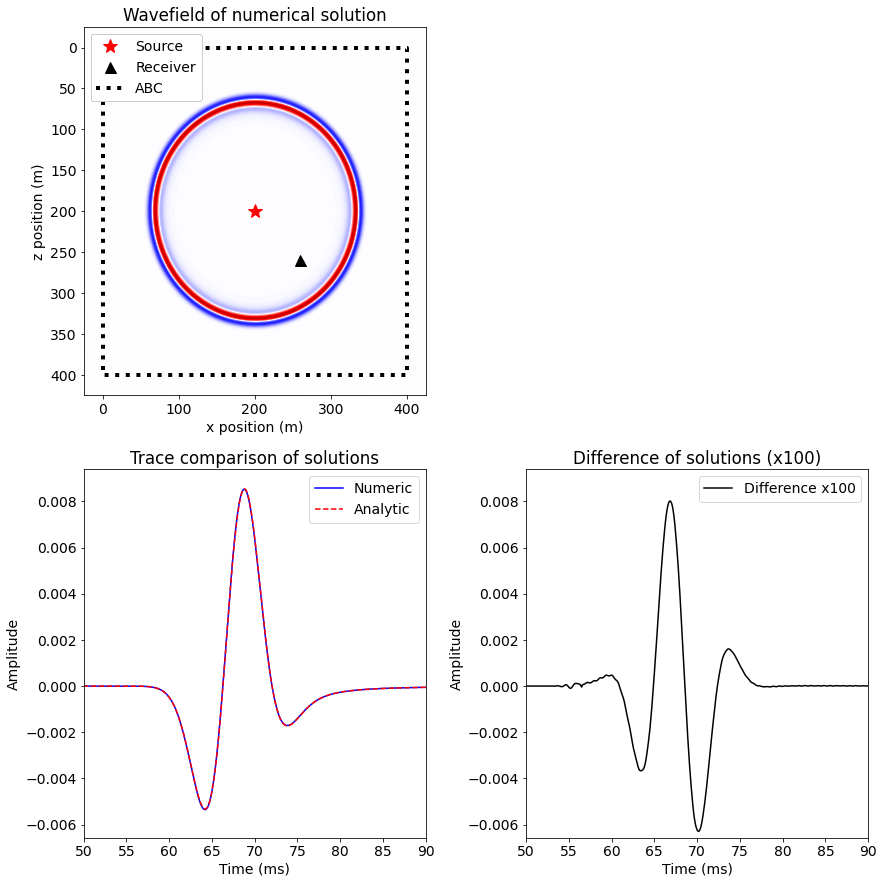

In [4]:
# Plot
x1 = origin[0]
x2 = origin[0] + extent[0]
z1 = origin[1]
z2 = origin[1] + extent[1]

xABC1 = origin[0] + dx * npad
xABC2 = origin[0] + extent[0] - dx * npad
zABC1 = origin[1] + dz * npad
zABC2 = origin[1] + extent[1] - dz * npad

plt_extent = [x1, x2, z2, z1]
abc_pairsX = [xABC1, xABC1, xABC2, xABC2, xABC1] 
abc_pairsZ = [zABC1, zABC2, zABC2, zABC1, zABC1] 

plt.figure(figsize=(12.5,12.5))

# Plot wavefield
plt.subplot(2,2,1)
amax = 1.1 * np.max(np.abs(recNum.data[:]))
plt.imshow(uNum.data[1,:,:], vmin=-amax, vmax=+amax, cmap="seismic",
           aspect="auto", extent=plt_extent)
plt.plot(src_coords[0, 0], src_coords[0, 1], 'r*', markersize=15, label='Source') 
plt.plot(rec_coords[0, 0], rec_coords[0, 1], 'k^', markersize=11, label='Receiver') 
plt.plot(abc_pairsX, abc_pairsZ, 'black', linewidth=4, linestyle=':', 
         label="ABC")
plt.legend(loc="upper left", bbox_to_anchor=(0.0, 0.9, 0.35, .1), framealpha=1.0)
plt.xlabel('x position (m)')
plt.ylabel('z position (m)')
plt.title('Wavefield of numerical solution')
plt.tight_layout()

# Plot trace
plt.subplot(2,2,3)
plt.plot(time, recNum.data[:, 0], '-b', label='Numeric')
plt.plot(time, uAna[:], '--r', label='Analytic')
plt.xlim([50,90])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Trace comparison of solutions')
plt.legend(loc="upper right")
plt.ylim([-0.7 * amax, +amax])

plt.subplot(2,2,4)
plt.plot(time, 100 * (recNum.data[:, 0] -  uAna[:]), '-k', label='Difference x100')
plt.xlim([50,90])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Difference of solutions (x100)')
plt.legend(loc="upper right")
plt.ylim([-0.7 * amax, +amax])

plt.tight_layout()
plt.show()

<a id="c_F_linearity"></a>
## 2. Modeling operator linearity test, with respect to source
For random vectors $s$ and $r$, prove:

$$
\begin{aligned}
F[m]\ (\alpha\ s) &\approx \alpha\ F[m]\ s \\[5pt]
F[m]^\top (\alpha\ r) &\approx \alpha\ F[m]^\top r \\[5pt]
\end{aligned}
$$

<br>


<a id="c_F_adjoint"></a>
## 3. Modeling operator adjoint test, with respect to source
For random vectors $s$ and $r$, prove:

$$
r \cdot F[m]\ s \approx s \cdot F[m]^\top r
$$

<br>


<a id="c_F_linearization"></a>
## 4. Nonlinear operator linearization test, with respect to model
For initial velocity model $m$ and random perturbation $\delta m$ prove that the $L_2$ norm error in the linearization $E(h)$ is second order (decreases quadratically) with the magnitude of the perturbation.

$$
E(h) = \biggl\|\ f(m+h\ \delta m) - f(m) - h\ \nabla F[m]\ \delta m\ \biggr\|
$$

One way to do this is to run a suite of $h$ values decreasing by a factor of $\gamma$, and prove the error decreases by a factor of $\gamma^2$:  

$$
\frac{E\left(h\right)}{E\left(h/\gamma\right)} \approx \gamma^2
$$

Elsewhere in Devito tutorials, this relation is proven by fitting a line to a sequence of $E(h)$ for various $h$ and showing second order error decrease.

<br>


<a id="c_J_linearity"></a>
## 5. Jacobian operator linearity test, with respect to model
For initial velocity model $m$ and random vectors $\delta m$ and $\delta r$, prove:

$$
\begin{aligned}
\nabla F[m]\ (\alpha\ \delta m) &\approx \alpha\ \nabla F[m]\ \delta m \\[5pt]
(\nabla F[m])^\top (\alpha\ \delta r) &\approx \alpha\ (\nabla F[m])^\top \delta r
\end{aligned}
$$

<br>


<a id="c_J_adjoint"></a>
## 6. Jacobian operator adjoint test, with respect to model
For initial velocity model $m$ and random vectors $\delta m$ and $\delta r$, prove:

$$
\delta r \cdot \nabla F[m]\ \delta m \approx \delta m \cdot (\nabla F[m])^\top \delta r
$$

<br>


<a id="refs"></a>
## References

- **A nonreflecting boundary condition for discrete acoustic and elastic wave equations** (1985)
<br>Charles Cerjan, Dan Kosloff, Ronnie Kosloff, and Moshe Resheq
<br> Geophysics, Vol. 50, No. 4
<br>https://library.seg.org/doi/pdfplus/10.1190/segam2016-13878451.1

- **Generation of Finite Difference Formulas on Arbitrarily Spaced Grids** (1988)
<br>Bengt Fornberg
<br>Mathematics of Computation, Vol. 51, No. 184
<br>http://dx.doi.org/10.1090/S0025-5718-1988-0935077-0
<br>https://web.njit.edu/~jiang/math712/fornberg.pdf

- **Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1
